# Persistent Homology using Ripser
- Input: embedding pickle file 
    - stored as a dict (name: model, embedding)
- Output: dgms (list of np arrays per dimension/homology group rank)

notes:
- stimulus key: cex=color exchange, dg=drifting gratings, cg=chromatic gratings, lf=luminance flash

Author: @emilyekstrum
<br> 12/09/25

In [2]:
#load modules
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from ripser import ripser
import random
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from persim import plot_diagrams
import seaborn as sns
import os

In [3]:
# Import TDA utilities
# RUN ME

import sys
from pathlib import Path

# Add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# Initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# Print summary of available data
data_manager.print_summary()

Spike data already available.
Extracting persistence diagrams from all_dgms.zip
Extracted to: c:\Users\denmanlab\Desktop\Emily_rotation\TDA\data\all_dgms
TDA utilities loaded
TDA Data Manager Info
Workspace root: c:\Users\denmanlab\Desktop\Emily_rotation\TDA
Data directory: c:\Users\denmanlab\Desktop\Emily_rotation\TDA\data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 5 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 14 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGN_chromatic_gratings.pkl
  • LGN_color_exchange.pkl
  • LGN_drifting_gratings.pkl
  • LGN_luminance_flash.pkl
  • V1_chromatic_gratings.pkl
  and 3 more


In [4]:
#utils for TDA analysis
# RUN ME

#randomly downsample embeddings
def downsample_embedding(embed, n_target=1000, seed=42): 
    """Downsamples embedding to n_target points using random sampling without replacement.
    Args:
        embed : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_target : int, target number of points after downsampling.
    Returns:
        downsampled_embed : np.ndarray of shape (n_target, D) if N > n_target, else original embed."""
    
    embed = np.asarray(embed, dtype=np.float32)
    N = embed.shape[0]
    if N <= n_target:
        return embed
    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=n_target, replace=False)
    print("Downsampling done")
    return embed[idx]

# farthest point sampling (FPS) downsample embeddings
def fps_downsample_embedding(embed, n_target=1000, seed=42):
    """Downsamples embedding to n_target points using either random sampling or Farthest Point Sampling (FPS).
    Args:
        embed : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_target : int, target number of points after downsampling.
        method : str, either "random" or "fps" to specify downsampling method.
    Returns:
        downsampled_embed : np.ndarray of shape (n_target, D) if N > n_target, else original embed."""
    
    N = embed.shape[0]
    print(N)
    if n_target >= N:
        return embed  
    
    rng = np.random.default_rng(seed)

    idxs = [rng.integers(N)]
    dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

    for _ in range(1, n_target):
        next_idx = np.argmax(dists)
        idxs.append(next_idx)
        new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
        dists = np.minimum(dists, new_dists)

    return embed[idxs]
    

# embedding to KNN sparse matrix
def knn_sparse_dist(embedding, n_neighbors=300, metric="cosine", plot = False, plot_title= " "):
    """Makes symmetric KNN sparse distance matrix -> input for ripser
       Can also plot heatmap of distance matrix subset
       
    Args:
        embedding : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_neighbors : int, number of nearest neighbors to consider for each point.
        metric : str, distance metric to use (default is "cosine").
        plot : bool, whether to plot heatmap of distance matrix subset.
        plot_title : str, title for the heatmap plot.
    Returns:
        sparse_matrix : scipy.sparse.csr_matrix of shape (N, N) representing the symmetric KNN distance matrix."""
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding, return_distance=True)        
    num_samples = embedding.shape[0]
    rows = np.repeat(np.arange(num_samples), n_neighbors)
    cols = indices.ravel()
    vals = distances.ravel().astype(np.float32)

    sparse_matrix = csr_matrix((vals, (rows, cols)), shape=(num_samples, num_samples))

    # symmetrize with min distance on shared edges
    sparse_matrix = sparse_matrix.minimum(sparse_matrix.transpose())

    if plot == True:
        m = min(600, sparse_matrix.shape[0])
        dense_sub = sparse_matrix[:m, :m]
        mask_sub = (dense_sub == 0)

        sns.heatmap(dense_sub, mask=mask_sub, cmap='viridis', square=True, cbar_kws ={'label' : 'Distance'})
        plt.title(plot_title)
        plt.show()
    return sparse_matrix


# ripser - TDA persistent homology heavy lifting
def tda_ripser(distance_matrix, name, maxdim=2, region='LGN', dims=3, stim = "cex", embed_type = "CEBRA", plot = False):
    """ Computes persistence diagrams and optionally plots them.
    
    Args:
        distance_matrix : np.ndarray or scipy.sparse matrix representing the distance matrix.
        name : str, name of the dataset/session.
        maxdim : int, maximum homology dimension to compute (default is 2).
        region : str, brain region (default is 'LGN').
        dims : int, embedding dimension (default is 3).
        stim : str, stimulus type (default is "cex").
        embed_type : str, type of embedding (default is "CEBRA").
        plot : bool, whether to plot the persistence diagrams (default is False).
    Returns:
        dgms : list of np.ndarray, persistence diagrams for each homology dimension."""

    dgms = ripser(distance_matrix, distance_matrix=True, maxdim=maxdim)['dgms']

    if plot == True:
        plot_diagrams(dgms, title=(f"Persistence Diagram \n{region} - {name} - {stim} - {dims}d"), show=True)
    
    return dgms

## 1. Load in available CEBRA embeddings

In [5]:
# find and list available CEBRA embedding files
available_embeddings = data_manager.find_files("*.pkl", "cebra_examples")

if available_embeddings:
    print(f"{len(available_embeddings)} CEBRA embedding files:")
    for i, path in enumerate(available_embeddings, 1):
        # parse filename info
        info = data_manager.parse_filename_info(path)
        print(f"  {i}. {path.name}")
        print(f"     Region: {info['region']}, Dimension: {info['dimension']}, Stimulus: {info['stimulus']}")
    
    print(f"\nTo process a specific file, set 'selected_embedding_index' below (1-{len(available_embeddings)})")
else:
    print("No CEBRA embedding files found.")
    print("Run the CEBRA embeddings notebook first to generate embeddings.")

5 CEBRA embedding files:
  1. LGN_3d_CEBRA_unsup_time_chromatic_gratings.pkl
     Region: LGN, Dimension: 3d, Stimulus: chromatic_gratings
  2. LGN_3d_CEBRA_unsup_time_color_exchange.pkl
     Region: LGN, Dimension: 3d, Stimulus: color_exchange
  3. LGN_8d_CEBRA_unsup_time_color_exchange.pkl
     Region: LGN, Dimension: 8d, Stimulus: color_exchange
  4. V1_3d_CEBRA_unsup_time_color_exchange.pkl
     Region: V1, Dimension: 3d, Stimulus: color_exchange
  5. V1_8d_CEBRA_unsup_time_color_exchange.pkl
     Region: V1, Dimension: 8d, Stimulus: color_exchange

To process a specific file, set 'selected_embedding_index' below (1-5)


## 2. Select an embedding file to process through Ripser
- args that can be changed:
    - ```selected_embedding_index``` - change index to pick a different CEBRA embedding file as listed above from the previous cell output

In [7]:
selected_embedding_index = 4  # change this to select a different file (1-based index)

# get embeddings to process
if available_embeddings:

    # use the first available embedding if index is out of range
    if selected_embedding_index < 1 or selected_embedding_index > len(available_embeddings):
        selected_embedding_index = 1
        print(f"Index out of range, using first available embedding")
    
    # get the selected embedding
    selected_embedding_path = available_embeddings[selected_embedding_index - 1]
    embedding_info = data_manager.parse_filename_info(selected_embedding_path)
    
    print(f"Selected: {selected_embedding_path.name}")
    print(f"Metadata: {embedding_info}")
    
    # file info
    embed_type = "CEBRA"
    dims = int(embedding_info['dimension'].replace('d', '')) if embedding_info['dimension'] != 'unknown' else 3
    region = embedding_info['region'] if embedding_info['region'] != 'unknown' else "LGN"
    stim = embedding_info['stimulus'] if embedding_info['stimulus'] != 'unknown' else "cex"
    
    print(f"\nParams:")
    print(f"  Embedding type: {embed_type}")
    print(f"  Dimensions: {dims}d")
    print(f"  Region: {region}")
    print(f"  Stimulus: {stim}")


Selected: V1_3d_CEBRA_unsup_time_color_exchange.pkl
Metadata: {'region': 'V1', 'dimension': '3d', 'stimulus': 'color_exchange', 'mouse_id': 'unknown', 'is_shuffled': False, 'is_random': False, 'filename': 'V1_3d_CEBRA_unsup_time_color_exchange.pkl', 'stem': 'V1_3d_CEBRA_unsup_time_color_exchange'}

Params:
  Embedding type: CEBRA
  Dimensions: 3d
  Region: V1
  Stimulus: color_exchange


## 3. Process selected embedding through Ripser


### TDA mini lesson: Persistence Diagrams

- Persistence diagram
    - plots birth/death values of a topological feature throughout Vietoris-Rips filtration
    - features closer to horizontal dashed line = more "persistent" throughout the filtration
        - they "survive" a longer interval of the filtration
    - features close to diagonal dashed line = noise
        - die soon after they are born; local features that are likely not representative of the global embedding topology
        
- Hn features
    - total count of per homology group features that exist in the embedding space representaion

![pd](persistent_homology_1d.gif)


gif source: https://medium.com/data-science/persistent-homology-with-examples-1974d4b9c3d0

As the filtration progresses, topological features are born (x-axis) when the growing disks around each point overlap and form a topological feature (ex. connected components and closed cycles in 2D). When this occurs, the birth value is recorded as the disk radius. The features die when the disks fill the space of the feature, and the disk radius is recorded for the death value.

**Each feature is plotted as (birth,death) on the persistence diagram**

Ripser computes these (birth,death) pairs. Rather than inputting a point cloud as input for the filtration, this pipeline computes a KNN sparse distance matrix with a high k value to maintain global relationships while still skimming down the required computation. This pipeline also downsamples the embeddings using farthest point sampling to maintain global structure, but keep the computation relatively lightweight.

### Set params for Ripser
- ```maxdim``` = max homology group rank to use in persistent homology/Ripser TDA 
    
- ```n_neighbors``` = neighbors for KNN sparse dist matrix construction
    - larger n_neighbors = more global structure described, trade-off with computational cost
    - smaller n_neighbors = less global structure described, faster computation

In [8]:
# params

#KNN matrix parameters
n_neighbors = 300 
matrix_metric = 'cosine'
plot_matrix = False
matrix_plot_title = f"{region} {stim} - Distance Matrix"

#Ripser parameters
plot_dgms = True # to plot persistence diagram
maxdim = 2 # homology groups - *note* increasing this significantly increases computation time

Loading model: Using CPU


c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


loaded model
moving d4 model from cuda:0 to cpu
Loaded embedding with sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']

Session: d4
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


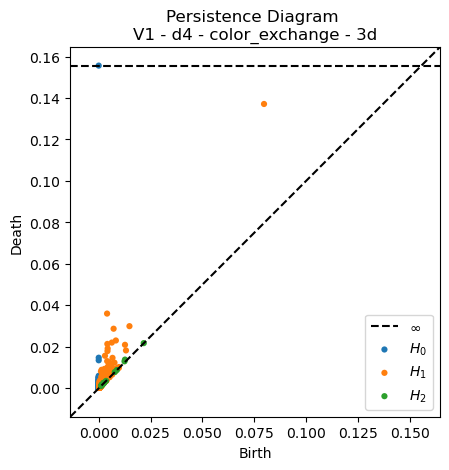

Total topological feature count for session d4:
    H0: 10000 features
    H1: 4662 features
    H2: 21 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 0 persistent features
    H2: 0 persistent features

Session: d5
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


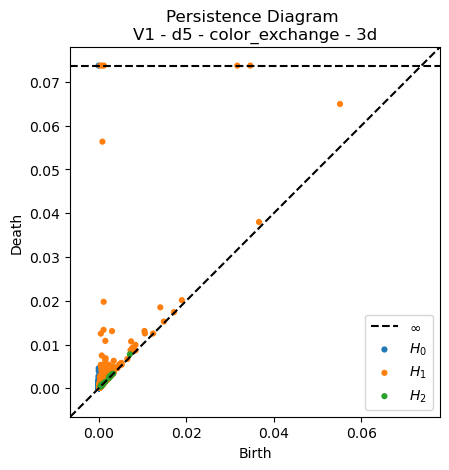

Total topological feature count for session d5:
    H0: 10000 features
    H1: 4007 features
    H2: 22 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 5 persistent features
    H2: 0 persistent features

Session: d6
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


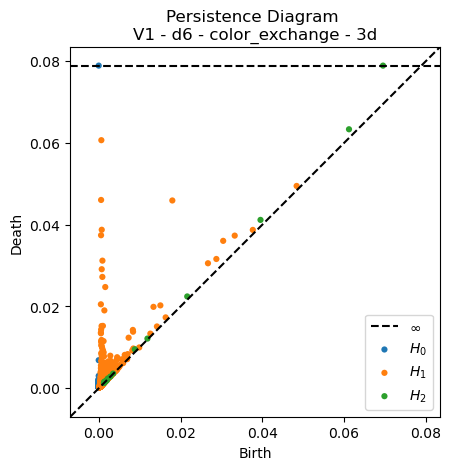

Total topological feature count for session d6:
    H0: 10000 features
    H1: 4358 features
    H2: 18 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 0 persistent features
    H2: 1 persistent features

Session: C153
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


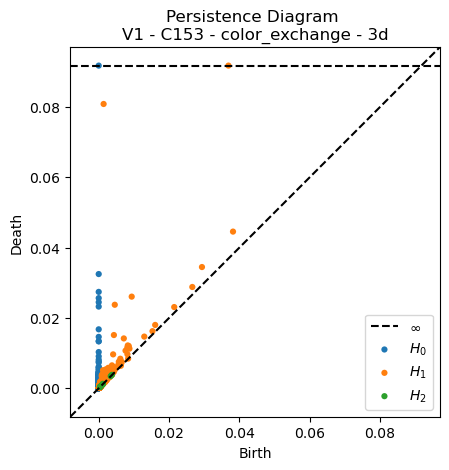

Total topological feature count for session C153:
    H0: 10000 features
    H1: 4279 features
    H2: 12 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 1 persistent features
    H2: 0 persistent features

Session: C155
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


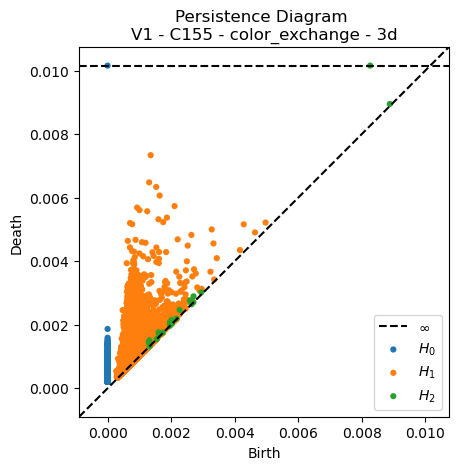

Total topological feature count for session C155:
    H0: 10000 features
    H1: 4567 features
    H2: 21 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 0 persistent features
    H2: 1 persistent features

Session: C159
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


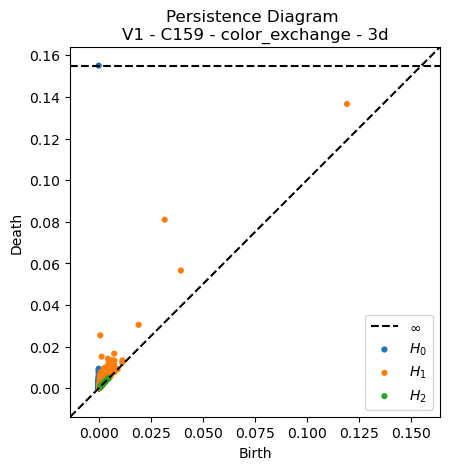

Total topological feature count for session C159:
    H0: 10000 features
    H1: 4408 features
    H2: 23 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 0 persistent features
    H2: 0 persistent features

Session: C160
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


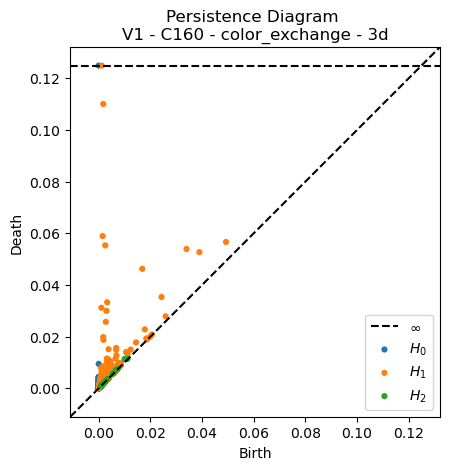

Total topological feature count for session C160:
    H0: 10000 features
    H1: 4338 features
    H2: 22 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 1 persistent features
    H2: 0 persistent features

Session: C161
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points
34000
  Using cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


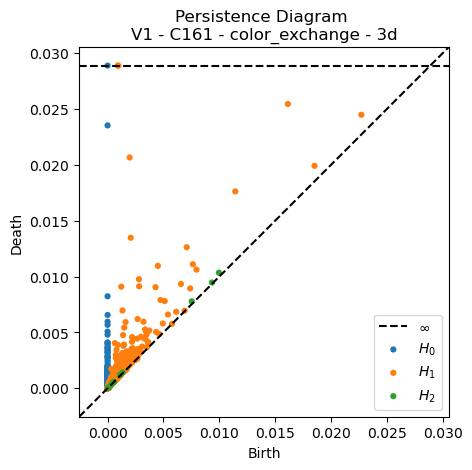

Total topological feature count for session C161:
    H0: 10000 features
    H1: 3600 features
    H2: 11 features

Persistent topological feature counts (death = infinity): 
    H0: 1 persistent features
    H1: 2 persistent features
    H2: 0 persistent features


In [9]:
# process embeddings
if available_embeddings:
    try:
        # load embedding data
        session_dict, session_names = data_manager.load_embedding_data(selected_embedding_path)
        print(f"Loaded embedding with sessions: {session_names}")
        
        # process each session
        all_dgms = {}
        
        for session_name in session_names:
            print(f"\nSession: {session_name}")
            
            # get the embedding for session
            embedding = session_dict[session_name]['embedding']
            print(f"  Original embedding shape: {embedding.shape}")
            
            # downsample if needed (recommend)
            if embedding.shape[0] > 10000:
                print(f"  Downsampling from {embedding.shape[0]} to 10000 points")
                ds_embedding = fps_downsample_embedding(embedding, n_target=10000)
            else:
                ds_embedding = embedding
                print(f"  Using full embedding ({embedding.shape[0]} points)")
            
            # create KNN sparse matrix
            print(f"  Using {matrix_metric} distance matrix with k={n_neighbors}")
            sparse_matrix = knn_sparse_dist(ds_embedding, n_neighbors, matrix_metric, plot_matrix, matrix_plot_title)
            
            # compute persistence diagrams
            print(f"  Computing persistence diagrams (max dimension {maxdim})")
            dgms = tda_ripser(sparse_matrix, session_name, maxdim, region, dims, stim, embed_type, plot=plot_dgms)
            
            # store results
            all_dgms[session_name] = dgms
            
            print(f"Total topological feature count for session {session_name}:")
            # show some stats
            for i, dgm in enumerate(dgms):
                if dgm is not None and len(dgm) > 0:
                    print(f"    H{i}: {len(dgm)} features")
                else:
                    print(f"    H{i}: 0 features")

            print("\nPersistent topological feature counts (death = infinity): ")
            for i, dgm in enumerate(dgms):
                if dgm is not None and len(dgm) > 0:
                    inf_count = np.sum(np.isinf(dgm[:, 1]))
                    print(f"    H{i}: {inf_count} persistent features")
                else:
                    print(f"    H{i}: 0 persistent features")
    
        
        # with open(output_path, 'wb') as f:
        #     pkl.dump(all_dgms, f)
        
        # print(f"\nSaved all persistence diagrams to: {output_path}")
        
    except Exception as e:
        print(f"Error processing embedding: {e}")
        import traceback
        traceback.print_exc()

### Homology group rank topological features
- H0: connected components
    - total count should reflect how many data points were input into Ripser (ex. 10,000)
- H1: closed cycles/2D circles
- H2: 3D enclosed voids/cavitites

### Persistent topological features that never die (death epsilon value = infinity), are called Betti numbers
- Betti numbers describe topological invariants
- distinguish the topologly of the embedding space
- ex: 
    - a sphere is topologically described with a Betti number sequence *H0:1 H1:0 H2:1*
    - a torus is topologicaly described with a Betti number sequence *H0:1 H1:2 H2:1*

## Or process an individual session through ripser

In [ ]:
# see available sessions/mouse IDs in the embedding file
if available_embeddings:
    print("\nAvailable sessions in the selected embedding:")
    for session_name in session_names:
        print(f"  - {session_name}")


Available sessions in the selected embedding:
  - d4
  - d5
  - d6
  - C153
  - C155
  - C159
  - C160
  - C161


Loading model: Using CPU
CUDA compatibility issue detected, forcing CPU mapping
Successfully loaded using custom CPU unpickler
Moving d4 model from cuda:0 to cpu
Loaded embedding with sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000


/opt/anaconda3/lib/python3.13/site-packages/torch/_weights_only_unpickler.py:552: UserWarning: Detected pickle protocol 4 in the checkpoint, which was not the default pickle protocol used by `torch.load` (2). The weights_only Unpickler might not support all instructions implemented by this protocol, please file an issue for adding support if you encounter this.
  warnings.warn(


  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


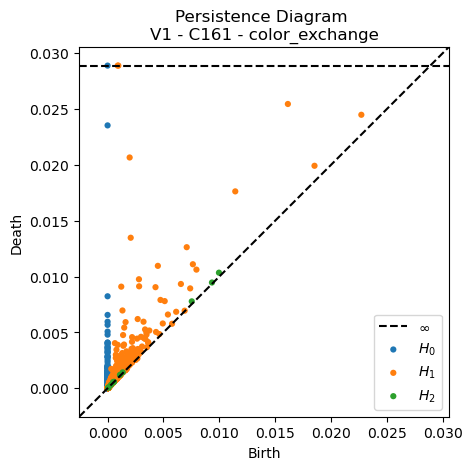

    H0: 10000 features
    H1: 3600 features
    H2: 11 features


In [ ]:
# to process an individual session in an embedding

session_name = "C161"  # set to session name string to process a specific session

if available_embeddings:
    try:
        # load embedding data
        session_dict, session_names = data_manager.load_embedding_data(selected_embedding_path)
        print(f"Loaded embedding with sessions: {session_names}")
        
        if session_name is not None:
            
            # get the embedding for session
            embedding = session_dict[session_name]['embedding']
            print(f"  Original embedding shape: {embedding.shape}")
            
            # downsample if needed (recommend)
            if embedding.shape[0] > 10000:
                print(f"  Downsampling from {embedding.shape[0]} to 10000 points...")
                ds_embedding = fps_downsample_embedding(embedding, n_target=10000)
            else:
                ds_embedding = embedding
                print(f"  Using full embedding ({embedding.shape[0]} points)")
            
            # create KNN sparse matrix
            print(f"  Creating {matrix_metric} distance matrix with k={n_neighbors}")
            sparse_matrix = knn_sparse_dist(ds_embedding, n_neighbors, matrix_metric, plot_matrix, matrix_plot_title)
            
            # compute persistence diagrams
            print(f"  Computing persistence diagrams (max dimension {maxdim})")
            dgms = tda_ripser(sparse_matrix, session_name, maxdim, region, dims, stim, embed_type, plot=plot_dgms)
            
            # store results
            all_dgms[session_name] = dgms
            
            # show some stats
            for i, dgm in enumerate(dgms):
                if dgm is not None and len(dgm) > 0:
                    print(f"    H{i}: {len(dgm)} features")
                else:
                    print(f"    H{i}: 0 features")
        
    except Exception as e:
        print(f"Error processing embedding: {e}")
        import traceback
        traceback.print_exc()

## 4. Save to all_dgms_dir to use in future notebooks

In [7]:
# save persistence diagrams using dgms metadata
if available_embeddings and 'all_dgms' in locals() and all_dgms:
    try:
        for session_name, dgms in all_dgms.items():
            # filename
            filename_parts = [embed_type, f"{dims}d", region, stim, session_name]
            output_filename = "_".join(filename_parts) + ".pkl"
            
            # save to persistence examples directory
            output_path = data_manager.get_output_path(output_filename, 'all_dgms_dir')
            
            print(f"Saving {session_name} persistence diagrams to: {output_path.name}")
            
            with open(output_path, 'wb') as f:
                pkl.dump(dgms, f)
        
        print(f"\nAll persistence diagrams saved")
        print(f"Location: {data_manager.data_paths['all_dgms_dir']}")
        
    except Exception as e:
        print(f"Error saving results: {e}")
        import traceback
        traceback.print_exc()

Saving d4 persistence diagrams to: CEBRA_3d_V1_color_exchange_d4.pkl
Saving d5 persistence diagrams to: CEBRA_3d_V1_color_exchange_d5.pkl
Saving d6 persistence diagrams to: CEBRA_3d_V1_color_exchange_d6.pkl
Saving C153 persistence diagrams to: CEBRA_3d_V1_color_exchange_C153.pkl
Saving C155 persistence diagrams to: CEBRA_3d_V1_color_exchange_C155.pkl
Saving C159 persistence diagrams to: CEBRA_3d_V1_color_exchange_C159.pkl
Saving C160 persistence diagrams to: CEBRA_3d_V1_color_exchange_C160.pkl
Saving C161 persistence diagrams to: CEBRA_3d_V1_color_exchange_C161.pkl

All persistence diagrams saved
Location: /Users/emilyekstrum/repos/TDA/data/all_dgms


# Manual Configuration 
- to manually specify paths and parameters, use the cells below:

In [ ]:
# manual configuration - specify parameters
# run this if you want to override the params above

manual_mode = False  # Set to True to use manual config

if manual_mode:
    # get available embedding files
    cebra_files = data_manager.find_files("*.pkl", "cebra_examples")
    
    if cebra_files:
        # select a specific file by name pattern
        embedding_path = None
        target_pattern = "LGN_3d_CEBRA"  # change this to match file
        
        for file_path in cebra_files:
            if target_pattern.lower() in file_path.name.lower():
                embedding_path = file_path
                break
        
        if embedding_path:
            print(f"Found file: {embedding_path.name}")
            
            # manual parameters
            embed_type = "CEBRA"
            session_names_to_process = ["C153"]  # specify which sessions/mouse ID to process
            dims = 3
            stim = "cex"
            maxdim = 2
            region = "LGN"
            
            # process with manual settings
            session_dict = pd.read_pickle(embedding_path)
            print(f"Available sessions: {list(session_dict.keys())}")
            
        else:
            print(f"No file matching pattern '{target_pattern}' found")
    else:
        print("No CEBRA embedding files found")

## Plot persistence diagrams

22 saved persistence diagram files:
  1. CEBRA_3d_V1_color_exchange_d6.pkl
  2. CEBRA_3d_V1_color_exchange_C159.pkl
  3. CEBRA_3d_V1_color_exchange_d5.pkl
  4. CEBRA_3d_V1_color_exchange_d4.pkl
  5. CEBRA_3d_LGN_cex_C159.pkl

Testing: CEBRA_3d_LGN_cex_C159.pkl
3 homology dimensions
  H0: 10000 persistence features
  H1: 4180 persistence features
  H2: 15 persistence features


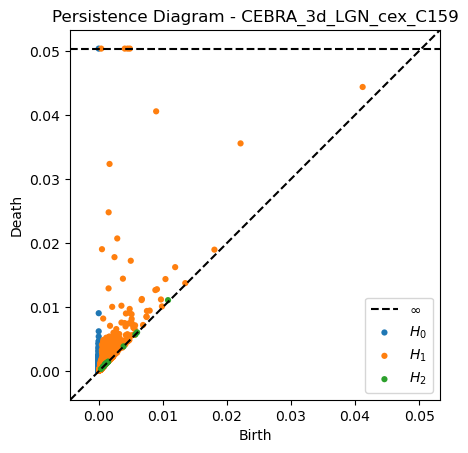

In [9]:
# plot saved persistence diagrams
saved_dgms = data_manager.find_files("*.pkl", "persistence_examples")

if saved_dgms:
    print(f"{len(saved_dgms)} saved persistence diagram files:")
    for i, path in enumerate(saved_dgms[-5:], 1):  # show last 5
        print(f"  {i}. {path.name}")
    
    # test loading one of them
    if saved_dgms:
        test_path = saved_dgms[-1]  # use the most recent one or change to another index
        print(f"\nTesting: {test_path.name}")
        
        try:
            test_dgms = data_manager.load_persistence_diagrams(test_path)
            print(f"{len(test_dgms)} homology dimensions")
            for i, dgm in enumerate(test_dgms):
                if dgm is not None and len(dgm) > 0:
                    print(f"  H{i}: {len(dgm)} persistence features")
                else:
                    print(f"  H{i}: 0 features")
            
            # optionally plot the persistence diagram
            plot_test_dgm = True
            if plot_test_dgm:
                plot_diagrams(test_dgms, title=f"Persistence Diagram - {test_path.stem}", show=True)
            
        except Exception as e:
            print(f"Error loading test file: {e}")
else:
    print("No persistence diagram files found.")
    print("Run the processing cells above to generate them.")